# Semester 3 Coding Portfolio Topic 3 Summative:
# Linear Regression

In this notebook, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [2]:
# TODO: Please enter your student number here
STUDENT_NUMBER = 15854493

# SUMMATIVE ASSESSMENT

For this summative assignment, we ask you to find a dataset from an internet source of choice. You will then analyze this dataset using linear regression and interpret the results.

The general assessment criteria for all summative assignments are mentioned in the assignment description on Canvas. Each notebook also has a few specific criteria we look for; make sure you fulfil them in your approach to this assignment.
In general, make sure this notebook represents a complete project: Write an explanation of what you are hoping to achieve with your analysis, document your code well, and present results in a comprehensive way.

## Assessment criteria specific to linear regression
 - Linear regression is properly implemented using a suitable dataset.
 - The R-squaredvalue was checked to determine how well the model explained the variance in thedependent variable.
 - Coefficients were examined to assess whether the predictors had a statistically significant relationship with the dependent variable.
 - The differences between observed and predicted values were analyzed to ensure they were randomly distributed.
 - Multicollinearity among predictors was checked using Correlation Matrices, and steps were taken to remove multicollinear variables where needed, to ensure proper convergence of the optimizer.
 - Correctly Splits the data into training, validation and test. If no Validation, provides sensible reasoning in the comments. 
 - Fits and compares a number of models (minimum 2) under the appropriate comparison metrics.
 - In their interpretation of the comparison students correctly interpret the direction and magnitude of the metrics.
 - Calculates the generalisation error of the model. Offers a distribution or an interval around the generalisation error.

Pick a dataset of your choice. Please ensure your dataset is a csv file under 100MB named sem3_topic3_linreg_summative_data.csv

<table>
<tr>
<td style="vertical-align: top; padding-right: 20px;">

**BACKSTORY**


Amsterdam is a city of clubs and music, however I do not tend to frequent those establishments. Apart from me being a more of a jazz and not techno person, I prefer relaxed dancing to the music (the appeal of a club packed with people makes me think of sardines in a can). 


I also did professional ballroom dancing for 11 years, so even if I don't like clubs and techno I LOVE to dance. I have been using spotify for YEARS to listen to my favourite tunes (hashtag ILOVE🇸🇪), so when I came across a Kaggle dataset on spotify songs - I loved the idea of considering this dataset for the assignment.


So in this notebook I will be **(1) predicting popularity from the danceability**, and similarly **(2) predicting popularity from a set of other variables**. 

PS: **this is me in the photo!**  


Another PS: if anyone is worried about ethical consideration - I have **consent** from my dance partner to display the image!!

</td>

<td>
<img src="./cool-dance.png" width="750">
</td>
</tr>
</table>


In [3]:
# Do NOT modify the contents of this cell. Start your customization in the next one!
import pandas as pd

custom_data_path = "sem3_topic3_linreg_summative_data.csv"
custom_df = pd.read_csv(custom_data_path)

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

## LOAD DATASET

In [5]:
#load data
custom_data_path = "sem3_topic3_linreg_summative_data.csv"
custom_df = pd.read_csv(custom_data_path)

df = pd.read_csv("sem3_topic3_linreg_summative_data.csv")
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nMissing values: {df.isnull().sum().sum()}")
df.head(3)

Dataset: 114000 rows, 21 columns

Missing values: 3


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


In [6]:
stats = df.describe()
print(stats)

          Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -1

In [7]:
df_clean = df[
    (df['popularity'] > 0) &  # - zero-popularity (invalid)
    (df['duration_ms'] <= 600000) &  # - extreme duration outliers
    (df['time_signature'] > 0)  # - invalid time signatures
].copy()

print(f"Rows before: {len(df)}, after: {len(df_clean)}")

Rows before: 114000, after: 97290


In [8]:
# drop rows with any missing values (only 3 rows)
df_final = df_clean.dropna()

# drop identifier columns that won't help prediction
df_final = df_clean.drop(columns=["Unnamed: 0", "track_id", "track_name", "album_name", "artists"])

print(f"Clean dataset: {df_final.shape[0]} rows, {df_final.shape[1]} columns")

Clean dataset: 97290 rows, 16 columns


## Multicollinearity (Correlation Matrix)

**Why?** Highly correlated predictors (multicollinearity) can make linear regression coefficients unstable and hard to interpret. We check for pairs with |correlation| > 0.85.

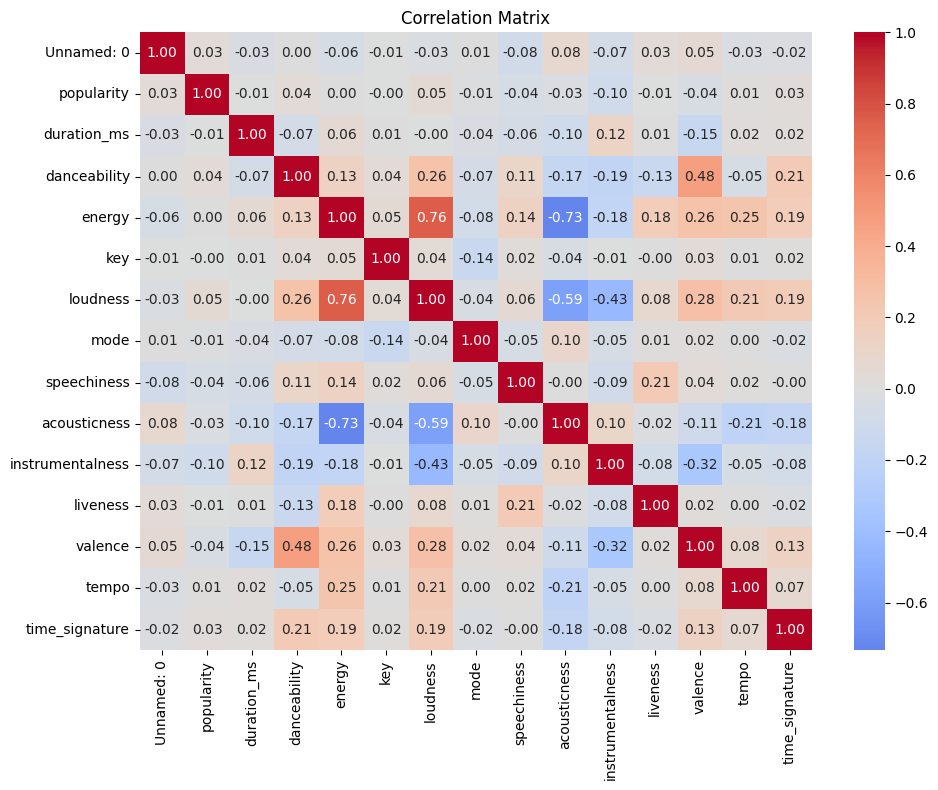

In [9]:
# select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [10]:
# check for highly correlated pairs (threshold = 0.85)
print("Checking for multicollinearity (|correlation| > 0.85):")
high_corr_found = False

for i in range(len(numeric_cols)):
    for j in range(i + 1, len(numeric_cols)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.85:
            print(f"  {numeric_cols[i]} & {numeric_cols[j]}: {corr_value:.3f}")
            high_corr_found = True

if not high_corr_found:
    print("  No highly correlated pairs found - no features need removal.")

Checking for multicollinearity (|correlation| > 0.85):
  No highly correlated pairs found - no features need removal.


**Interpretation** 

No feature pairs exceed the 0.85 threshold, so I keep all features. However, I observe


- Energy & loudness have moderate positive correlation <VALUE> - louder songs tend to be more energetic


- Energy & acousticness have negative correlation <VALUE> - energetic songs tend not to be acoustic


- Popularity has weak correlations with all features - suggesting non-linear relationships may exist

## Train/Validation/Test Split

**3 splits because**
- **Training (70%)** so model can learn meaningful patterns
- **Validation (15%)** so i can compare my first (linreg) and second(random forest)
- **Test (15%)** for final evaluating when i validated which model performs better

In [11]:
# define features (X) and target (y)
X = df.drop(columns=["popularity"])
y = df["popularity"]

# first split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# second split: 50/50 of temp = 15% validation, 15% test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f"Training set:   {X_train.shape[0]} samples")
print(f"Validation set: {X_valid.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")

Training set:   79800 samples
Validation set: 17100 samples
Test set:       17100 samples


## Preprocessing Pipeline

The `track_genre` column is categorical (like pop, rock, etc). I will use One-Hot Encoding to convert it to numeric columns

In [14]:
#ident categorical and numeric columns
cat_cols = ["track_genre"]
num_cols = [col for col in X.columns if col not in cat_cols]

#OneHotEncode the genre
#its a transformer class created and used within pipilens
#for me it transforms the track_genre column into multiple binary columns so the model can use them
#pass numeric columns through unchanged
one_hot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
categorical_features = ["track_genre"]

preprocess = ColumnTransformer(
    transformers=[
        ("genre_encoder", one_hot, categorical_features)
    ],
    remainder="passthrough"  # keep every other column unchanged
)


## MODEL 1: LINREG

In [15]:
linreg = Pipeline([
    ("prep", preprocess),            # preprocessing from Step 2
    ("model", LinearRegression())    # the linear regression model
])

#fitting the model on TRAINING data
linreg.fit(X_train, y_train)

#predict on VALIDATION data
pred_lr = linreg.predict(X_valid)


mae_lr = mean_absolute_error(y_valid, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_valid, pred_lr))
r2_lr = r2_score(y_valid, pred_lr)

print("Linear Regression Performance (Validation Set)")
print("MAE:  ", mae_lr)
print("RMSE: ", rmse_lr)
print("R²:   ", r2_lr)

ValueError: could not convert string to float: '7hUhmkALyQ8SX9mJs5XI3D'

### Coefficient Analysis (stats significance)

I will use statsmodels to get p-values and check which predictors have statistically significant relationships with popularity

In [ ]:
# transform training data for statsmodels
X_train_transformed = preprocess.fit_transform(X_train)
feature_names = preprocess.get_feature_names_out()

# convert sparse to dense
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
# add constant (intercept) for statsmodels
X_train_sm = sm.add_constant(X_train_transformed)

# fit OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# show summary for numeric features only (genres are too many)
# extract coefficients for numeric features
coef_df = pd.DataFrame({
    'Feature': ['const'] + list(feature_names),
    'Coefficient': ols_model.params,
    'p-value': ols_model.pvalues
})

# filter to show numeric features
numeric_features = coef_df[coef_df['Feature'].str.startswith(('const', 'num__'))]
print("Coefficient Significance (numeric features):")
print(numeric_features.to_string(index=False))
print("\nNote: p-value < 0.05 indicates statistical significance")

NameError: name 'preprocess' is not defined